In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import tensorflow as tf

In [2]:
train_folder_path = r'C:../dataset/audioonly/labeled/set 2/Train'
os.path.exists(train_folder_path)

True

In [3]:
class_names = next(os.walk(train_folder_path))[1]
class_names = class_names[1:]
class_names

['belly_pain', 'discomfort', 'hungry', 'tired']

In [4]:
audio_path = [os.path.join(train_folder_path, name) for name in class_names]
audio_path

['C:../dataset/audioonly/labeled/set 2/Train\\belly_pain',
 'C:../dataset/audioonly/labeled/set 2/Train\\discomfort',
 'C:../dataset/audioonly/labeled/set 2/Train\\hungry',
 'C:../dataset/audioonly/labeled/set 2/Train\\tired']

In [5]:
bpain_audio = glob.glob(os.path.join(audio_path[0], '*.wav'))
discomf_audio = glob.glob(os.path.join(audio_path[1], '*.wav'))
hungry_audio = glob.glob(os.path.join(audio_path[2], '*.wav'))
tired_audio = glob.glob(os.path.join(audio_path[3], '*.wav'))

In [6]:
audio_path_byclass = {
    'bpain': bpain_audio,
    'discomf': discomf_audio,
    'hungry': hungry_audio,
    'tired': tired_audio
}

# Load Audio

In [7]:
# Replace 'your_audio_file.mp3' with the path to your audio file
load_audio = {}
for name, pathlst in audio_path_byclass.items():
    loaded = []
    for path in pathlst:
        audio, sr = librosa.load(path, sr=16000, mono=True, duration=5.2)
        loaded.append(audio)
    load_audio[name] = loaded

In [8]:
mfcc_audio = {}
for name, pathlst in audio_path_byclass.items():
    mfccs = []
    for path in pathlst:
        audio, sr = librosa.load(path, sr=16000, mono=True, duration=5.0)
        mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=10)
        mfccs.append(mfcc)
    mfcc_audio[name] = mfccs

In [9]:
import collections

shape = {}

for class_name, lst in mfcc_audio.items():
    for arr in lst:
        shapes = [arr.shape for arr in lst]
        shapes_count = collections.Counter(shapes)
        shape[f'{class_name} mfcc shape counts'] = shapes_count

In [10]:
shape

{'bpain mfcc shape counts': Counter({(10, 157): 69}),
 'discomf mfcc shape counts': Counter({(10, 157): 94}),
 'hungry mfcc shape counts': Counter({(10, 157): 100}),
 'tired mfcc shape counts': Counter({(10, 157): 69})}

## Load Model

In [11]:
# Load the model.
import tensorflow_hub as hub
model = hub.load('https://tfhub.dev/google/yamnet/1')

In [12]:
# Run the model, check the output.
feature = {}
for name, arr in load_audio.items():
    # Initialize dictionaries for each class if not already existing
    if name not in feature:
        feature[name] = {'scores': [], 'embeddings': []}
    
    for wav in arr:
        scores, embeddings, spectrogram = model(wav)
        
        # Append the results to the respective lists in the dictionary
        feature[name]['scores'].append(np.array(scores))
        feature[name]['embeddings'].append(np.array(embeddings))

In [13]:
shape_feat = {}

for class_name in feature.keys():
    for cat, lst in feature[class_name].items():
        shapes = [arr.shape for arr in lst]
        shapes_count = collections.Counter(shapes)
        shape_feat[f'{class_name} {cat} shape counts'] = shapes_count

In [14]:
shape_feat

{'bpain scores shape counts': Counter({(10, 521): 69}),
 'bpain embeddings shape counts': Counter({(10, 1024): 69}),
 'discomf scores shape counts': Counter({(10, 521): 94}),
 'discomf embeddings shape counts': Counter({(10, 1024): 94}),
 'hungry scores shape counts': Counter({(10, 521): 100}),
 'hungry embeddings shape counts': Counter({(10, 1024): 100}),
 'tired scores shape counts': Counter({(10, 521): 69}),
 'tired embeddings shape counts': Counter({(10, 1024): 69})}

## Padding

In [15]:
from statistics import mean

temp = [521, 1024, 157]
avg = int(mean(temp))

In [16]:
for class_name, lst in mfcc_audio.items():
    feature[class_name]['mfcc'] = lst

In [17]:
shape_feat_3d = {}

for class_name in feature.keys():
    for cat, lst in feature[class_name].items():
        shapes = [arr.shape for arr in lst]
        shapes_count = collections.Counter(shapes)
        shape_feat_3d[f'{class_name} {cat} shape counts'] = shapes_count

In [18]:
shape_feat_3d

{'bpain scores shape counts': Counter({(10, 521): 69}),
 'bpain embeddings shape counts': Counter({(10, 1024): 69}),
 'bpain mfcc shape counts': Counter({(10, 157): 69}),
 'discomf scores shape counts': Counter({(10, 521): 94}),
 'discomf embeddings shape counts': Counter({(10, 1024): 94}),
 'discomf mfcc shape counts': Counter({(10, 157): 94}),
 'hungry scores shape counts': Counter({(10, 521): 100}),
 'hungry embeddings shape counts': Counter({(10, 1024): 100}),
 'hungry mfcc shape counts': Counter({(10, 157): 100}),
 'tired scores shape counts': Counter({(10, 521): 69}),
 'tired embeddings shape counts': Counter({(10, 1024): 69}),
 'tired mfcc shape counts': Counter({(10, 157): 69})}

In [19]:
reshaped = {}

for class_name, categories in feature.items():
    for cat, lst in categories.items():
        temp = []
        for arr in lst:
            h, w = arr.shape
            size = h * w

            if size == 5210 or size == 1570:
                padded = np.pad(arr, pad_width=((0, 0), (0, 1024 - w)), mode='constant', constant_values=0)
                temp.append(padded)
            elif size == 10240:
                temp.append(arr)
        
        reshaped[f'{class_name} {cat}'] = temp

In [20]:
shape_count = {}

for class_name, lst in reshaped.items():
    shapes = [arr.shape for arr in lst]
    shapes_count = collections.Counter(shapes)
    shape_count[f'{class_name} shape counts'] = shapes_count

In [21]:
shape_count

{'bpain scores shape counts': Counter({(10, 1024): 69}),
 'bpain embeddings shape counts': Counter({(10, 1024): 69}),
 'bpain mfcc shape counts': Counter({(10, 1024): 69}),
 'discomf scores shape counts': Counter({(10, 1024): 94}),
 'discomf embeddings shape counts': Counter({(10, 1024): 94}),
 'discomf mfcc shape counts': Counter({(10, 1024): 94}),
 'hungry scores shape counts': Counter({(10, 1024): 100}),
 'hungry embeddings shape counts': Counter({(10, 1024): 100}),
 'hungry mfcc shape counts': Counter({(10, 1024): 100}),
 'tired scores shape counts': Counter({(10, 1024): 69}),
 'tired embeddings shape counts': Counter({(10, 1024): 69}),
 'tired mfcc shape counts': Counter({(10, 1024): 69})}

In [22]:
# Function to combine the data for each category into a 3-channel format
def combine_data(category):
    score_key = f'{category} scores'
    embeddings_key = f'{category} embeddings'
    mfcc_key = f'{category} mfcc'
    return np.stack((reshaped[score_key], reshaped[embeddings_key], reshaped[mfcc_key]), axis=-1)

In [23]:
# Combine the data for each category
combined_data = {category: combine_data(category) for category in ['bpain', 'discomf', 'hungry', 'tired']}

# Display the shapes of the combined data for verification
for category, data in combined_data.items():
    print(f"{category}: {data.shape}")

# Return the shape of the bpain data
combined_data['bpain'].shape

bpain: (69, 10, 1024, 3)
discomf: (94, 10, 1024, 3)
hungry: (100, 10, 1024, 3)
tired: (69, 10, 1024, 3)


(69, 10, 1024, 3)

In [24]:
from sklearn.model_selection import train_test_split

# Labels for each category
labels = {
    'bpain': 0,
    'discomf': 1,
    'hungry': 2,
    'tired': 3
}

# Combine all data and labels
all_data = []
all_labels = []
for category, data in combined_data.items():
    all_data.append(data)
    all_labels.append(np.full((data.shape[0],), labels[category]))

# Convert lists to numpy arrays
all_data = np.concatenate(all_data)
all_labels = np.concatenate(all_labels)

# Shuffle the data and labels in unison
shuffle_indices = np.random.permutation(np.arange(len(all_labels)))
all_data_shuffled = all_data[shuffle_indices]
all_labels_shuffled = all_labels[shuffle_indices]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(all_data_shuffled, all_labels_shuffled, test_size=0.2, random_state=42)

# Verifying the shapes of the resulting arrays
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((265, 10, 1024, 3), (265,), (67, 10, 1024, 3), (67,))

## Model Training

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, MaxPooling2D, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2, l1

# Define the input shape
input_shape = (10, 1024, 3)

# Create a sequential model
model = Sequential()

# Add a convolutional layer with LeakyReLU activation
model.add(Conv2D(filters=64, kernel_size=(2, 2), input_shape=input_shape))  # You can adjust the alpha value as needed
model.add(LeakyReLU(alpha=0.022))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Add another convolutional layer with LeakyReLU activation
model.add(Conv2D(filters=128, kernel_size=(2, 2)))
model.add(LeakyReLU(alpha=0.022))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(BatchNormalization())

# model.add(Conv2D(filters=64, kernel_size=(2, 2)))
# model.add(LeakyReLU(alpha=0.021))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add a dense layer with LeakyReLU activation
model.add(Dense(128, kernel_regularizer=l2(0.001)))
model.add(LeakyReLU(alpha=0.022)) # Adjusting alpha

# model.add(Dense(64, kernel_regularizer=l2(0.001)))
# model.add(LeakyReLU(alpha=0.022))

# Add the output layer
model.add(Dense(units=4, activation='softmax'))  # Assuming 4 classes as per your data

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 1023, 64)       832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 9, 1023, 64)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 511, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 4, 511, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 510, 128)       32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 3, 510, 128)       0

In [26]:
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_test, y_test),
                    epochs=30,
                    batch_size=4)

Epoch 1/30
67/67 [==============================] - 1s 11ms/step - loss: 3.8578 - accuracy: 0.3585 - val_loss: 1.6438 - val_accuracy: 0.3433
Epoch 2/30
67/67 [==============================] - 0s 6ms/step - loss: 1.5158 - accuracy: 0.4566 - val_loss: 1.6880 - val_accuracy: 0.3433
Epoch 3/30
67/67 [==============================] - 0s 6ms/step - loss: 1.4460 - accuracy: 0.5472 - val_loss: 2.1482 - val_accuracy: 0.3284
Epoch 4/30
67/67 [==============================] - 0s 6ms/step - loss: 1.2705 - accuracy: 0.5849 - val_loss: 1.6699 - val_accuracy: 0.3731
Epoch 5/30
67/67 [==============================] - 0s 6ms/step - loss: 1.2219 - accuracy: 0.6453 - val_loss: 2.9009 - val_accuracy: 0.3582
Epoch 6/30
67/67 [==============================] - 0s 6ms/step - loss: 1.1469 - accuracy: 0.6755 - val_loss: 1.7575 - val_accuracy: 0.5373
Epoch 7/30
67/67 [==============================] - 0s 6ms/step - loss: 0.9669 - accuracy: 0.7623 - val_loss: 1.7903 - val_accuracy: 0.4925
Epoch 8/30
67/67 [=

In [27]:
model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 5ms/step - loss: 3.1518 - accuracy: 0.5075


[3.15179181098938, 0.5074626803398132]

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

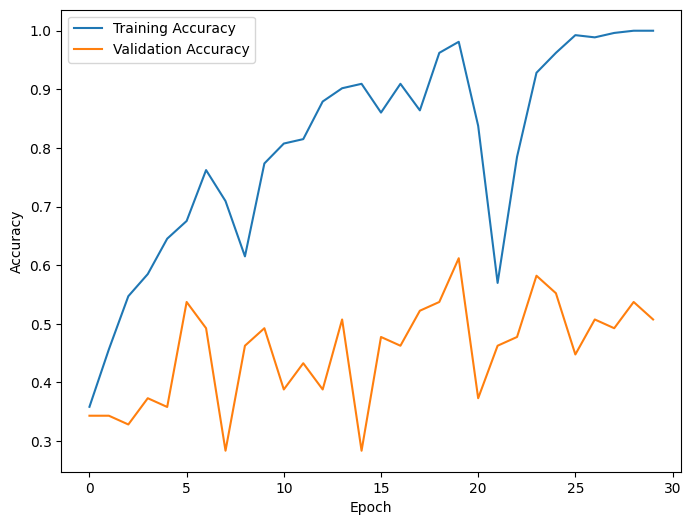

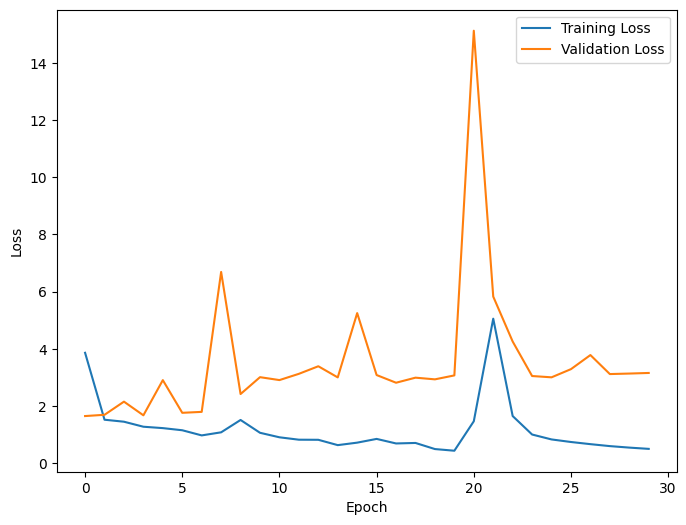

In [29]:
# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## XGBoost

In [33]:
train = np.load(r"C:\Users\dave\aiffel\EUANGGG\maincode\data\dataset\audioonly\labeled\set 2\xtrain.npy")
label = np.load(r"C:\Users\dave\aiffel\EUANGGG\maincode\data\dataset\audioonly\labeled\set 2\ytrain.npy")
test = np.load(r"C:\Users\dave\aiffel\EUANGGG\maincode\data\dataset\audioonly\labeled\set 2\xtest.npy")
test_label = np.load(r"C:\Users\dave\aiffel\EUANGGG\maincode\data\dataset\audioonly\labeled\set 2\ytest.npy")

In [34]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = xgb.XGBClassifier(objective='multi:softmax', num_class=4)
model.fit(train, label)
y_pred = model.predict(test)
accuracy = accuracy_score(test_label, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 50.75%


## random forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier model
model = RandomForestClassifier(n_estimators=70, random_state=42)

# Train the model
model.fit(train, label)

# Predict the labels for the test set
y_pred = model.predict(test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(test_label, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 65.67%
